# Assignment 2: NLP

## Envirnment Setup

Importing the dataset (needs to be done only once per notebook)

In [1]:
# needs to be run only once per notebook
# !wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# !tar -xzf aclImdb_v1.tar.gz

In [1]:
!cat aclImdb/imdb.vocab | wc -l # number of vocab words

89526


## Imports

In [111]:
import nltk # natural language tool kit: for text pre-processing
import os # for listing directories
from bs4 import BeautifulSoup as bs # library for removing html tags from text
import numpy as np # no comment :P
from nltk.corpus import stopwords # a set of common stopwords from nltk
from gensim import models
import gensim
from collections import namedtuple
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import wordnet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt


from pathlib import Path
# import helper functions
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import warnings
warnings.filterwarnings(action='once')

In [113]:
# download resources for nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [114]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '``', "''", '...'])

/usr/local/lib/python3.5/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/home/abdelrahman/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


## Reading the dataset and preprocessing the text

In [115]:
train_pos = []
train_neg = []
wnl = nltk.WordNetLemmatizer()

In [117]:
train_pos = read_data('aclImdb/train/pos')
print("read {} positive training reviews".format(len(train_pos)))

train_neg = read_data('aclImdb/train/neg')
print("read {} negative training reviews".format(len(train_neg)))

train_data = train_pos + train_neg
print(len(train_data))

read 12500 positive training reviews
read 12500 negative training reviews
25000


In [118]:
test_pos = read_data('aclImdb/test/pos')
print("read {} positive test reviews".format(len(test_pos)))

test_neg = read_data('aclImdb/test/neg')
print("read {} negative test reviews".format(len(test_neg)))

test_data = test_pos + test_neg
print(len(test_data))

read 12500 positive test reviews
read 12500 negative test reviews
25000


In [119]:
train_labels = np.array([1]*12500 + [0]*12500)
test_labels = np.array([1]*12500 + [0]*12500)

## Removing unbiased words

In [120]:
def countInFile(filename):
    with open(filename) as f:
        return Counter(chain.from_iterable(map(str.split, f)))

pos_data_count = countInFile('aclImdb/train/pos/all.txt')
neg_data_count = countInFile('aclImdb/train/neg/all.txt')

margin = 1.8 # biased words margin
unbiased_words = set()
for word in pos_data_count.keys():
    pos_count = pos_data_count[word]
    if word in neg_data_count:
        neg_count = neg_data_count[word]
        if pos_count > neg_count and pos_count < margin*neg_count:
            unbiased_words.add(word)
        elif neg_count > pos_count and neg_count < margin*pos_count:
            unbiased_words.add(word)
print("Found {} unbiased words".format(len(unbiased_words)))

Found 10494 unbiased words


## Set up hyper parameters and classifiers for cross fold validation

Here we define the parameters to be tuned for each classifier and create a classifier object for each combination of parameters.

In [121]:
logistic_params = {'C': [0.1, 0.5, 1, 5, 10]}
random_forest_params = {'n_estimators': [10,50,100,300]}
ada_params = {'n_estimators': [10, 50, 100], 'base_estimator':[LogisticRegression(C=5)]}
knn_params = {'n_neighbors': [5, 11, 17]}

lr_clfs = get_clfs_for_combinations(LogisticRegression, logistic_params)
rf_clfs = get_clfs_for_combinations(RandomForestClassifier, random_forest_params)
ada_clfs = get_clfs_for_combinations(AdaBoostClassifier, ada_params)
knn_clfs = get_clfs_for_combinations(KNeighborsClassifier, knn_params)

## TF-IDF

In [122]:
# put positive and negative training data in one file
!cat aclImdb/train/pos/all.txt aclImdb/train/neg/all.txt > all_train.txt
!cat aclImdb/test/pos/all.txt aclImdb/test/neg/all.txt > all_test.txt

In [128]:
# pass the Vectorizer the paramter stop_words=unbiased_words
# to remove unbiased words
tfidf = TfidfVectorizer()
all_train_file = open('all_train.txt', 'r')
train_doc_matrix = tfidf.fit_transform([review for review in all_train_file.readlines()])
all_train_file.close()

In [127]:
print(len(tfidf.vocabulary_))

67109


In [132]:
all_test_file = open('all_test.txt', 'r')
test_doc_matrix = tfidf.transform([review for review in all_test_file.readlines()])
all_test_file.close()

In [133]:
print(test_doc_matrix.shape)

(25000, 67109)


### cross validation testing

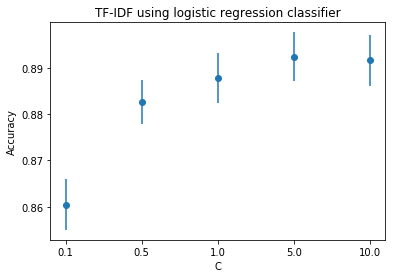

In [134]:
scores_dict = cross_validate(train_doc_matrix, train_labels, lr_clfs)
param = 'C'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='TF-IDF using logistic regression classifier')
fig.savefig('plots/tf-idf-lr')

In [135]:
scores_dict = cross_validate(train_doc_matrix, train_labels, knn_clfs)

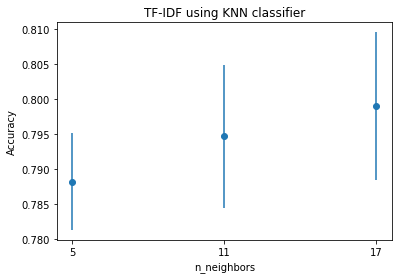

In [136]:
param = 'n_neighbors'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='TF-IDF using KNN classifier')
fig.savefig('plots/tf-idf-knn')

get IDF values for each word in the vocabulary to use it in weighting the word2vec vectors later on.

In [137]:
word_idfs = dict(zip(tfidf.get_feature_names(), tfidf._tfidf.idf_))

## Word2Vec trained on IMDB

In [138]:
word_dimensions = 100
model=Word2Vec(train_data, size = word_dimensions)

In [139]:
train_doc_vecs = get_doc_vecs_for_data(train_data, model.wv, word_dimensions, word_weights=word_idfs, ignored_words=unbiased_words)
test_doc_vecs = get_doc_vecs_for_data(test_data, model.wv, word_dimensions, word_weights=word_idfs, ignored_words=unbiased_words)

### cross validation testing using IDF weighted embeddings

In [153]:
scores_dict = cross_validate(train_doc_vecs, train_labels, lr_clfs)

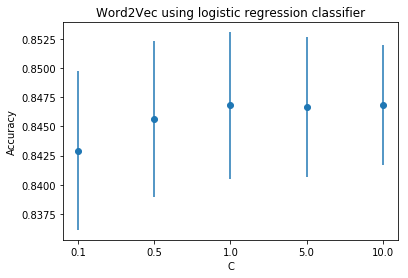

In [155]:
param = 'C'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='Word2Vec using logistic regression classifier')
fig.savefig('plots/word2vec-lr')

## Pretrained GloVe Embeddings

In [151]:
glove_dict_300 = load_glove_dict(300)

In [143]:
glove_train_doc_vecs = get_doc_vecs_for_data(train_data, glove_dict_300, 300, ignored_words=unbiased_words)
glove_test_doc_vecs = get_doc_vecs_for_data(test_data, glove_dict_300, 300, ignored_words=unbiased_words)

In [152]:
%reset_selective -f glove_dict_300

### cross validation testing

In [145]:
scores_dict = cross_validate(glove_train_doc_vecs, train_labels, lr_clfs)

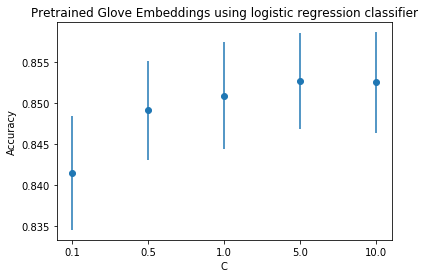

In [146]:
param = 'C'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='Pretrained Glove Embeddings using logistic regression classifier')
fig.savefig('plots/glove-lr')

In [147]:
scores_dict = cross_validate(glove_train_doc_vecs, train_labels, ada_clfs)

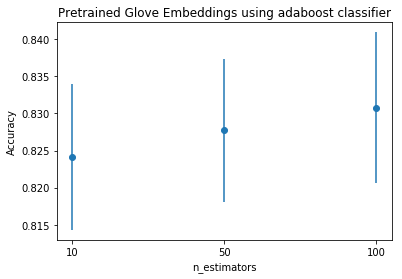

In [148]:
param = 'n_estimators'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param,
    title='Pretrained Glove Embeddings using adaboost classifier')
fig.savefig('plots/glove-ada')

In [149]:
# WARNING: takes long time to execute ~ 10-15 minutes
scores_dict = cross_validate(glove_train_doc_vecs, train_labels, knn_clfs)
print_clf_scores(scores_dict, knn_params.keys())

clf with params: [('n_neighbors', 5)], score: 0.82172
clf with params: [('n_neighbors', 11)], score: 0.8322
clf with params: [('n_neighbors', 17)], score: 0.8344000000000001


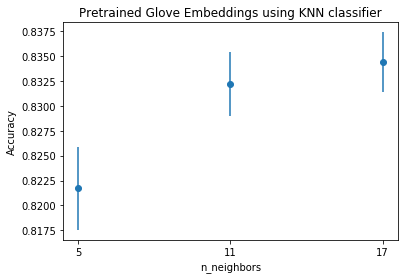

In [150]:
param = 'n_neighbors'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='Pretrained Glove Embeddings using KNN classifier')
fig.savefig('plots/glove-knn')

# Testing on the Real Test Data

## Classifiers

In [121]:
testing_clfs = [LogisticRegression(),
                RandomForestClassifier(),
                AdaBoostClassifier(),
                KNeighborsClassifier()]
clfs_names = ['Logistic', 'Random Forest', 'AdaBoost', 'KNN']

## Testing GloVe

In [123]:
def test(clfs, train_data, test_data, train_labels, test_labels):
    for i,clf in enumerate(clfs):
        clf.fit(train_data, train_labels)
        score = clf.score(test_data, test_labels)
        print("Classifier {} scored: {}".format(clfs_names[i], score))

## Testing Word2Vec trained on the Dataset

In [124]:
test(testing_clfs, train_doc_vecs, test_doc_vecs, train_labels, test_labels)

Classifier Logistic scored: 0.82864
Classifier Random Forest scored: 0.78564
Classifier AdaBoost scored: 0.8036
Classifier KNN scored: 0.78436


## Testing TF-IDF on Cleaned Data

In [127]:
test(testing_clfs, train_doc_matrix, test_doc_matrix, train_labels, test_labels)

Classifier Logistic scored: 0.87792
Classifier Random Forest scored: 0.74772
Classifier AdaBoost scored: 0.80208
Classifier KNN scored: 0.65028


# Preprocessing effect

We will run TF-IDF on the raw text. Since IDF already gives a low weight to the more frequent tokens/words, punctuations and stopwords will have a very low weight. We should expect TF-IDF on the raw data to yield a result similar to the cleaned data.

In [156]:
class FileIterator:
    def __init__(self, dirname):
        self.dirname = dirname
    def __iter__(self):
        pathlist = Path(self.dirname).glob('*_*.txt')
        for path in pathlist:
            path_in_str = str(path)
            if os.path.isfile(path_in_str):
                f = open(path_in_str)
                text = f.read()
                f.close()
                yield text

In [157]:
train_pos_iter = FileIterator('aclImdb/train/pos')
train_neg_iter = FileIterator('aclImdb/train/neg')
train_iter = chain(train_pos_iter, train_neg_iter)

test_pos_iter = FileIterator('aclImdb/test/pos')
test_neg_iter = FileIterator('aclImdb/test/neg')
test_iter = chain(test_pos_iter, test_neg_iter)

In [158]:
tfidf = TfidfVectorizer()
train_doc_matrix = tfidf.fit_transform(train_iter)
test_doc_matrix = tfidf.transform(test_iter)

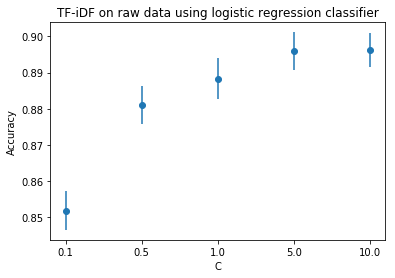

In [160]:
scores_dict = cross_validate(train_doc_matrix, train_labels, lr_clfs)
aram = 'C'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='TF-iDF on raw data using logistic regression classifier')
fig.savefig('plots/tf-idf-raw-lr')

In [131]:
test(testing_clfs, train_doc_matrix, test_doc_matrix, train_labels, test_labels)

Classifier Logistic scored: 0.88316
Classifier Random Forest scored: 0.73404
Classifier AdaBoost scored: 0.8034
Classifier KNN scored: 0.66152
